# 📝 Automatic speech-to-text transcription using the Transformers library and Whisper
_by Marianne de Heer Kloots, June 2025_

In this notebook we'll automatically generate text transcriptions for the audio files in the Tragic Talkers dataset!

We'll make use of the HuggingFace hub and the [transformers library](https://huggingface.co/docs/transformers/en/index) to load a state-of-the-art model for text transcription (i.e. Automatic Speech Recognition / ASR): `whisper-large-v3`. This model can return text transcripts as well as corresponding timestamps. We'll inspect how the model's performance varies for different recording types and microphones.

> ❗ **Note:** You probably want to activate a GPU backend to run the code in this notebook efficiently. <br>
> Click _Runtime > Change runtime type_ in the menu above this notebook to select a GPU runtime (your current session will disconnect and restart).

Run the three cells below to download, install and import the needed data, libraries and helper functions (no need to closely read their contents).

In [1]:
# @title Download data
!rm -rf 'sample_data'
!gdown -qq 1RXQ3u5RRsSq50mQWKDTj1rpKMUnTqIh0
!unzip -qq tragictalkers_speech_subset.zip
!rm tragictalkers_speech_subset.zip
!gdown -qq 1rKJuFcc9LA3m34sJ04Xl2Zm4xP4lute_
!unzip -qq whisper_outputs.zip
!rm whisper_outputs.zip

In [2]:
# @title Install libraries
!pip install -qq jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.3 MB/s eta 0:00:00


In [3]:
# @title Import libraries & helper functions
import torch
import os
import glob
import librosa
import json
import soundfile as sf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
from transformers.utils import logging
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from transformers.models.whisper.english_normalizer import BasicTextNormalizer
from datasets import Dataset, Audio
from jiwer import wer
import IPython.display as ipd
from IPython.display import Audio
logging.set_verbosity_error()
sns.set()

# helper functions
def find_wav_filepath(recording_name, mic_id):
  """
  Find the audio file for the specified recording and microphone.
  """
  return glob.glob(f'audio_subset/{recording_name}/{mic_id}-*.wav')[0]

def audio_player(audio_file):
  return ipd.display(Audio(audio_file))

We first load some information needed to iterate over audio files, as well as the human-validated transcripts (included in the Tragic Talkers data) that we can use as a reference to compare the model's performance against.

In [4]:
# all recording names (the folder names within audio_subset)
rec_names = sorted(os.listdir('audio_subset'))
mic_ids = [
    17, # romeo
    18, # juliet
    19  # ceiling
]
# reference transcripts for each of the recordings
rec_transcripts = pd.read_csv('transcripts_subset/recording_transcripts.csv')
turn_transcripts = pd.read_csv('transcripts_subset/turn_transcripts.csv')
def rec_transcript(rec_name):
  return rec_transcripts[rec_transcripts['recording'] == rec_name]['transcript'].item()
def turn_transcript(rec_name):
  return turn_transcripts[turn_transcripts['recording'] == rec_name]

Here we set up a transcription pipeline for the Whisper model! We load the model, as well as a _processor_ which we need to map from audio to model features (`processor.feature_extractor`) at the model's input as well as to map from model features to text tokens (`processor.tokenizer`) at the model's output.

For more options setting up a transcription pipeline, for example to specify decoding strategies or optimize memory usage, see the [HuggingFace documentation for the `whisper-large-v3` model](https://huggingface.co/openai/whisper-large-v3#usage).

In [5]:
# set device depending on runtime
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# HuggingFace identifier for Whisper model
model_id = "openai/whisper-large-v3"

# load model and send to device
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)
processor = AutoProcessor.from_pretrained(model_id)

# set up transcription pipeline
pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)

# text normalizer (for WER computation)
normalizer = BasicTextNormalizer()

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Let's inspect the model's transcription for a single example file!

In [6]:
# transcribe this recording and microphone track
rec_name = 'interactive2_t1'
mic_id = 19

audio_path = find_wav_filepath(rec_name, mic_id)

audio, sr = sf.read(audio_path)
result = pipe(audio)

model_transcript = result["text"]
reference = rec_transcript(rec_name)

audio_player(audio_path)

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


Below we print the model's generated transcript and the reference transcript. Can you spot any mistakes?

In [7]:
model_transcript

" Romeo. My dear. What o'clock tomorrow shall I send to thee? By the hour of nine. I will not fail. It is twenty years till then. I forget what it is to have thee here. Then I shall stay here, till thee remember it."

In [8]:
reference

'Romeo! My dear? What oclock tomorrow shall I send to thee? By the hour of nine. I will not fail. Tis twenty year till then. I forget what it is to have you here. Then I should stay here to thee remember it.'

The performance of text transcription models is often measured using the _Word Error Rate (WER)_ metric. WER is defined as follows:
```
WER = (S + D + I) / N
```
where `S` = number of substitutions, `D` = number of deletions, `I` = number of insertions, and `N` = number of words in the reference.

We can compute the WER for our example using the `wer` function from the [`jiwer`](https://pypi.org/project/jiwer/) library:

In [9]:
wer(reference, model_transcript)

0.23255813953488372

The default WER computation takes into account punctuation and capitalization as part of words. For a slightly more lenient measure, we can compute the _normalized WER_ over transcripts, where those aspects are removed:

In [10]:
normalized_transcript = normalizer(model_transcript)
print(normalized_transcript)
normalized_reference = normalizer(reference)
print(normalized_reference)
wer(normalized_reference, normalized_transcript)

 romeo my dear what o clock tomorrow shall i send to thee by the hour of nine i will not fail it is twenty years till then i forget what it is to have thee here then i shall stay here till thee remember it 
romeo my dear what oclock tomorrow shall i send to thee by the hour of nine i will not fail tis twenty year till then i forget what it is to have you here then i should stay here to thee remember it 


0.18604651162790697

The next cell extracts Whisper transcriptions for all audio recordings and computes their WER scores against the human references. It will take a few minutes to run!

If you don't want to wait, or can't access a GPU runtime, you can skip this cell and uncomment the cell below this one to load precomputed transcipts and timestamps.

In [11]:
rec_data = {
    'recording': [],
    'rec_type': [],
    'mic_id': [],
    'duration': [],
    'model_transcript': [],
    'reference': [],
    'wer': [],
    'normalized_wer': []
}
timestamps = {}
for rec_name, mic_id in tqdm(product(rec_names, mic_ids)):
    wav_file = find_wav_filepath(rec_name, mic_id)
    rec_data['recording'].append(rec_name)
    rec_data['rec_type'].append(rec_name.split('_')[0][:-1])
    rec_data['mic_id'].append(mic_id)
    duration = librosa.get_duration(path=wav_file)
    rec_data['duration'].append(duration)

    # load audio and transcribe
    audio, sr = sf.read(wav_file)
    result = pipe(
        audio, return_timestamps=True,
        generate_kwargs={"language": "english"}
    )
    timestamps[f'{rec_name}-{mic_id}'] = result["chunks"]

    # compute word error rate against human reference transcription
    model_transcript = result["text"]
    reference = rec_transcript(rec_name)
    wer_score = wer(reference, model_transcript)

    # compute word error rate for normalized transcription
    # (ignoring punctuation and capitalization)
    normalized_transcript = normalizer(model_transcript)
    normalized_reference = normalizer(reference)
    normalized_wer_score = wer(normalized_reference, normalized_transcript)

    rec_data['model_transcript'].append(model_transcript)
    rec_data['reference'].append(reference)
    rec_data['wer'].append(wer_score)
    rec_data['normalized_wer'].append(normalized_wer_score)
transcripts_df = pd.DataFrame.from_dict(rec_data)

0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
75it [05:02,  4.04s/it]


In [12]:
# # load precomputed transcipts and timestamps
# transcripts_df = pd.read_csv('whisper_transcripts.csv')
# timestamps = json.load(open('whisper_timestamps.json'))

We can now plot the model's normalized WER scores for each recording and microphone!
> **Exercise:** How does model transcription performance vary across the different recording types? What effects do you see when comparing results for the different microphones?

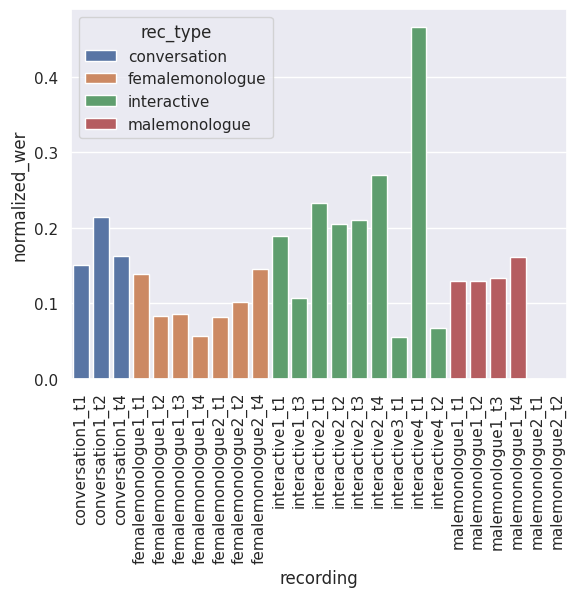

In [13]:
# plot WER scores across recordings for this microphone
mic_id = 19

plot_results = transcripts_df[transcripts_df['mic_id'] == mic_id]
fig, ax = plt.subplots()
sns.barplot(plot_results, x='recording', y='normalized_wer', hue='rec_type', ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
plt.show()

Whisper can also output timestamps for the start and end of each utterance in the transcript.
> **Exercise:** Compare the transcribed utterances and timestamps for a few different recordings and microphones using the cell below. Which microphone setting leads to the best results? Can you spot any hallucinations in the automatic transcriptions?

In [14]:
# look up Whisper's estimated timestamps and aligned transcripts for this recording and microphone
rec_name = 'interactive1_t1'
mic_id = 19

timestamps[f'{rec_name}-{mic_id}']

[{'timestamp': (0.0, 6.0),
  'text': " Romeo, my dear, what o'clock to-morrow shall I send to thee?"},
 {'timestamp': (6.0, 8.0), 'text': ' By the hour of nine.'},
 {'timestamp': (8.0, 11.0),
  'text': ' Who will not fail? Tis twenty years till then.'},
 {'timestamp': (11.0, 13.0),
  'text': ' I have forgot why I did ask thee back.'},
 {'timestamp': (13.0, 15.0),
  'text': ' Then I shall stay till thee remember it.'},
 {'timestamp': (15.0, 19.0),
  'text': ' I shall forget to have thee stand still in my company,'},
 {'timestamp': (19.0, 21.0), 'text': ' remembering how I loved thy so.'},
 {'timestamp': (21.0, 24.0),
  'text': ' And I shall stay still, still till thee forget,'},
 {'timestamp': (24.0, 28.14), 'text': ' forgetting any home but this.'}]

In [15]:
# look up the reference transcript for this recording
turn_transcript(rec_name)

,recording,speaker,start_time,end_time,transcript
22,interactive1_t1,Juliet,2.67,3.23,Romeo!
23,interactive1_t1,Romeo,3.30,3.87,My dear?
24,interactive1_t1,Juliet,4.30,5.63,What oclock tomorrow shall I send to thee?
25,interactive1_t1,Romeo,6.00,6.90,By the hour of nine.
26,interactive1_t1,Juliet,7.67,12.37,I will not fail. Tis twenty year till then. I ...
27,interactive1_t1,Romeo,12.70,14.27,Then I should stay to be remember it.
28,interactive1_t1,Juliet,15.23,20.33,"I shall forget, to have thee and still in my c..."
29,interactive1_t1,Romeo,21.27,25.67,"And I'll should stay still, still to thee forg..."


> **Final exercise:** Now that you've seen some results of automatic pipelines for audio processing, speaker diarization and text transcription, what would be your advice to a researcher working on automating their audio analysis and annotation pipeline for the Tragic Talkers dataset? Which microphone tracks should be used for which tasks? What outputs should probably be checked for what kinds of errors?

⏩ **Want to learn more** about using the Transformers library and the HuggingFace hub for audio processing tasks? Check out the [HuggingFace Audio course](https://huggingface.co/learn/audio-course/en/chapter0/introduction)!

Or would you like to learn how to inspect the inner workings of speech processing models? We'll soon release materials for our tutorial on _Interpretability Techniques for Speech Models_ at [this webpage](https://interpretingdl.github.io/speech-interpretability-tutorial/).